In [1]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split      # dividing the dataset
from sklearn.preprocessing import LabelEncoder            # for converting str labels to number
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sn
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all messages, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint ,Callback # type: ignore
from tensorflow.keras import layers, models ,optimizers # type: ignore
from tensorflow.keras.models import load_model # type: ignore
from tensorflow.keras.layers import GlobalAveragePooling2D # type: ignore
from tensorflow.keras.applications import EfficientNetB0 # type: ignore
import pathlib
import warnings
warnings.filterwarnings("ignore")

In [2]:
tf.version.VERSION

'2.16.1'

# Exploratory analysis of image data

In [2]:
# Basic review of the photos directory

def dataset_analysis(path):
    subfolders = os.listdir(path)

    for subfolder in subfolders:
        subfolder_path = os.path.join(path, subfolder)
        if os.path.isdir(subfolder_path):
            files = os.listdir(subfolder_path)
            format_dimensions_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

            for file in files:
                try:
                    file_path = os.path.join(subfolder_path, file)
                    with Image.open(file_path) as img:
                        image_type = img.format.upper()  # Format (e.g., JPEG, PNG)
                        image_dimensions = img.size  # (width, height)
                        image_mode = img.mode  # Mode (e.g., RGB, L)
                        
                        
                        # Calculate bit depth
                        if image_mode == "1":  # 1-bit pixels, black and white, stored with one pixel per byte
                            bit_depth = 1
                        elif image_mode == "L":  # 8-bit pixels, grayscale
                            bit_depth = 8
                        elif image_mode == "P":  # 8-bit pixels, mapped to any other mode using a color palette
                            bit_depth = 8
                        elif image_mode == "RGB":  # 8-bit pixels, true color
                            bit_depth = 24  # 8 bits per channel
                        elif image_mode == "RGBA":  # 8-bit pixels, true color with transparency mask
                            bit_depth = 32  # 8 bits per channel
                        elif image_mode == "CMYK":  # 8-bit pixels, color separation
                            bit_depth = 32  # 8 bits per channel
                        else:
                            bit_depth = "Unknown"
                        
                        format_dimensions_counts[image_type][(image_dimensions, bit_depth)][image_mode] += 1
                except Exception as e:
                    print(f"Exception processing '{file}' in '{subfolder}': {e}")
                    
            print('--------'*10)
            print(f"Subfolder '{subfolder}' contains ({len(files)} files):")
            for format, dimensions_counts in format_dimensions_counts.items():
                print(f"- {sum(sum(counts.values()) for counts in dimensions_counts.values())} images of format {format}:")
                for (dimensions, bit_depth), counts in dimensions_counts.items():
                    for mode, count in counts.items():
                        print(f"  - {count} images with dimensions {dimensions}, bit depth {bit_depth}, mode {mode}")
                        


path = r'/kaggle/input/eye-diseases-classification/dataset'
dataset_path = path
dataset_analysis(dataset_path)


--------------------------------------------------------------------------------
Subfolder 'glaucoma' contains (1007 files):
- 906 images of format JPEG:
  - 306 images with dimensions (512, 512), bit depth 24, mode RGB
  - 600 images with dimensions (256, 256), bit depth 24, mode RGB
- 101 images of format PNG:
  - 74 images with dimensions (2592, 1728), bit depth 24, mode RGB
  - 22 images with dimensions (2464, 1632), bit depth 24, mode RGB
  - 5 images with dimensions (1848, 1224), bit depth 24, mode RGB
--------------------------------------------------------------------------------
Subfolder 'normal' contains (1074 files):
- 1074 images of format JPEG:
  - 1074 images with dimensions (512, 512), bit depth 24, mode RGB
--------------------------------------------------------------------------------
Subfolder 'diabetic_retinopathy' contains (1098 files):
- 1098 images of format JPEG:
  - 1098 images with dimensions (512, 512), bit depth 24, mode RGB
--------------------------------

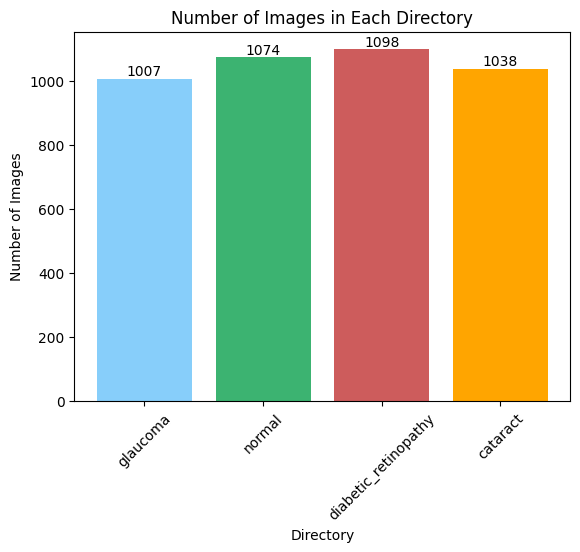

In [4]:
# Count the number of images in each directory
subfolders = os.listdir(path)
image_counts = []
for directory in subfolders:
    sub_dir = os.path.join(path, directory)
    if os.path.isdir(sub_dir):
        file_count = len(os.listdir(sub_dir))
        image_counts.append(file_count)
        
#Add value counts on each bar
for i in range(len(subfolders)):
    plt.text(i, image_counts[i], str(image_counts[i]), ha='center', va='bottom')
    
#Set some colors
colors = ['lightskyblue', 'mediumseagreen', 'indianred', 'orange']

# Plotting the results
plt.bar(subfolders, image_counts, color=colors)
plt.xlabel('Directory')
plt.xticks(rotation = 45)
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Directory')
plt.show()

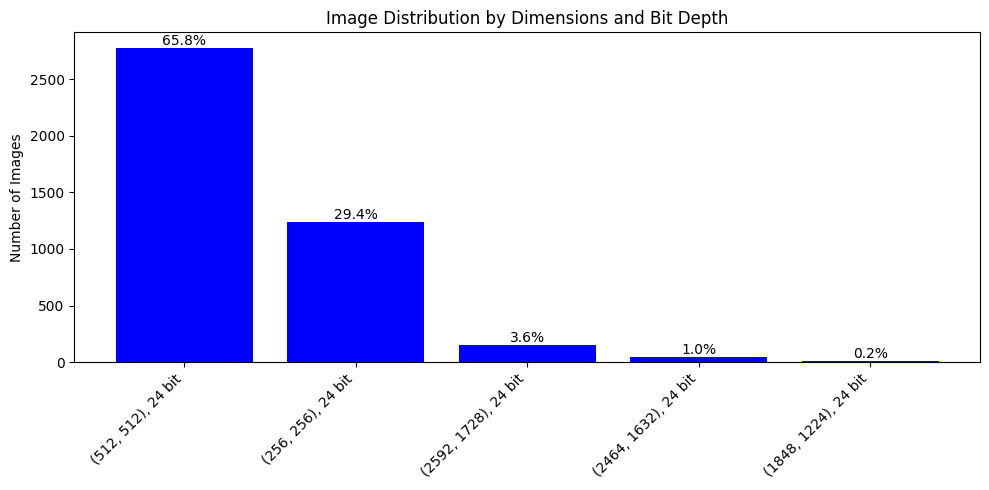

In [5]:
# Check the photos by size

def dataset_size_analysis(path):
    format_dimensions_counts = defaultdict(int)

    subfolders = os.listdir(path)
    for subfolder in subfolders:
        subfolder_path = os.path.join(path, subfolder)
        if os.path.isdir(subfolder_path):
            files = os.listdir(subfolder_path)

            for file in files:
                try:
                    file_path = os.path.join(subfolder_path, file)
                    with Image.open(file_path) as img:
                        image_dimensions = img.size
                        image_mode = img.mode

                        # Calculate bit depth
                        bit_depth = {
                            "1": 1,
                            "L": 8,
                            "P": 8,
                            "RGB": 24,
                            "RGBA": 32,
                            "CMYK": 32
                        }.get(image_mode, "Unknown")

                        # Update counts
                        format_dimensions_counts[(image_dimensions, bit_depth)] += 1

                except Exception as e:
                    print(f"Exception processing '{file}' in '{subfolder}': {e}")

    # Plotting dimensions and bit depths
    plt.figure(figsize=(10, 5))
    labels = [f"{dims}, {depth} bit" for (dims, depth) in format_dimensions_counts]
    sizes = list(format_dimensions_counts.values())
    total = sum(sizes)
    bars = plt.bar(labels, sizes, color='blue')
    plt.xticks(rotation=45, ha="right")
    plt.ylabel('Number of Images')
    plt.title('Image Distribution by Dimensions and Bit Depth')

    # Adding percentage labels above the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{100 * yval/total:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Set the path to the dataset directory
dataset_size_analysis(path)

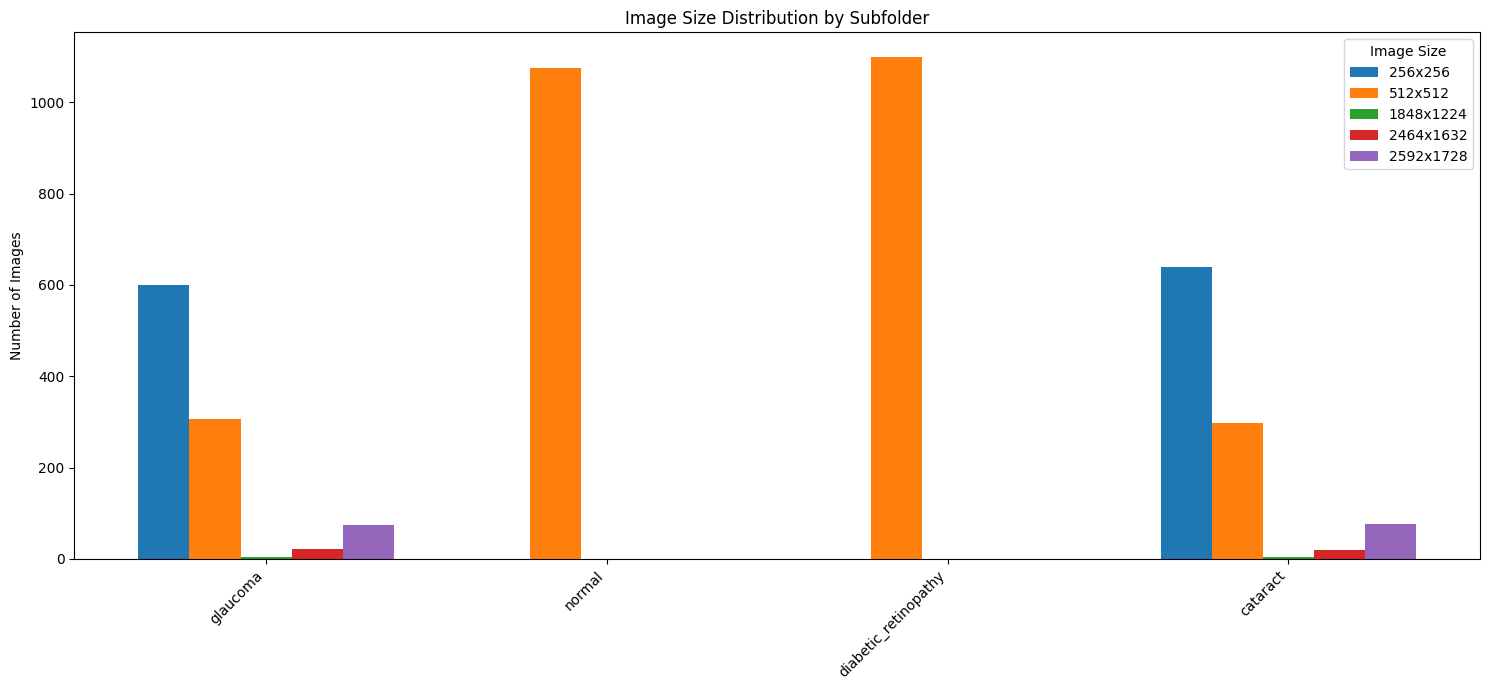

In [6]:


def dataset_size_analysis(path):
    # Dictionary to store counts: {subfolder: {image_size: count}}
    folder_size_counts = defaultdict(lambda: defaultdict(int))

    for subfolder in os.listdir(path):
        subfolder_path = os.path.join(path, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                try:
                    file_path = os.path.join(subfolder_path, file)
                    with Image.open(file_path) as img:
                        dims = img.size
                        folder_size_counts[subfolder][dims] += 1
                except Exception as e:
                    print(f"Exception processing '{file}' in '{subfolder}': {e}")

    # Create a single plot
    plt.figure(figsize=(15, 7))
    
    # Determine unique image sizes across all folders for consistent coloring and grouping
    all_sizes = set(size for sizes in folder_size_counts.values() for size in sizes)
    all_sizes = sorted(all_sizes, key=lambda s: (s[0] * s[1]))  # Sort by area

    subfolder_names = list(folder_size_counts.keys())
    bar_width = 0.15  # Width of bars
    indices = range(len(subfolder_names))

    for i, size in enumerate(all_sizes):
        counts = [folder_size_counts[subfolder].get(size, 0) for subfolder in subfolder_names]
        plt.bar([index + i * bar_width for index in indices], counts, bar_width, label=f'{size[0]}x{size[1]}')

    plt.xticks([index + (len(all_sizes) - 1) * bar_width / 2 for index in indices], subfolder_names, rotation=45, ha="right")
    plt.ylabel('Number of Images')
    plt.title('Image Size Distribution by Subfolder')
    plt.legend(title="Image Size")
    plt.tight_layout()
    plt.show()

# Set the path to the dataset directory
dataset_size_analysis(path)


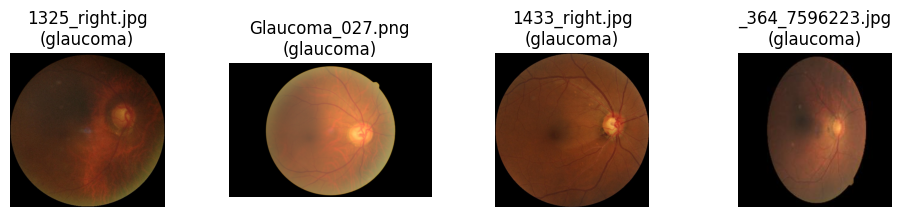

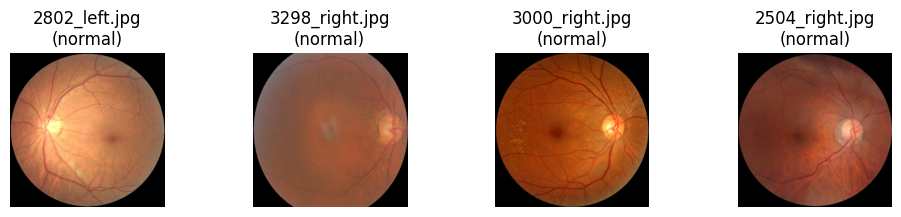

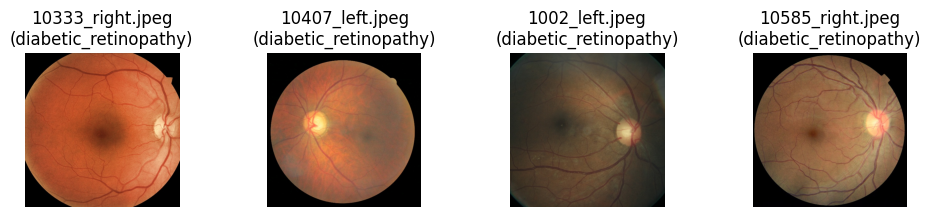

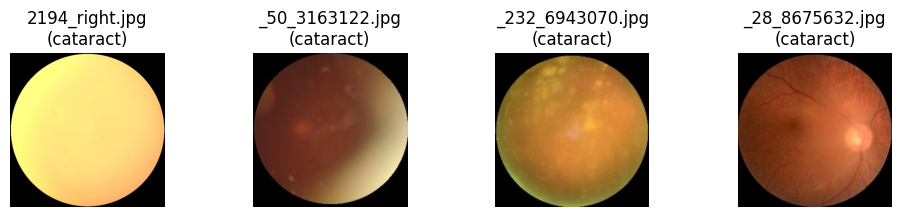

In [7]:
# Preview photos

def random_photos_from_folders(base_folder):
    # Walk through all directories and files in the base_folder
    for root, dirs, files in os.walk(base_folder):
        # Filter to get only files that are images
        images = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if len(images) >= 4:  # Ensure there are at least 4 images
            selected_images = random.sample(images, 4)  # Randomly select 4 images
            
            # Display selected images
            fig, axs = plt.subplots(1, 4, figsize=(12, 2))  # Create a 1x4 grid of plots
            for idx, img_name in enumerate(selected_images):
                img_path = os.path.join(root, img_name)
                img = Image.open(img_path)
                axs[idx].imshow(img)
                axs[idx].axis('off')  # Hide axes
                
                # Extract sub-folder name from the root path
                subfolder_name = os.path.basename(root)
                # Set the title to include image name and sub-folder name
                axs[idx].set_title(f"{img_name}\n({subfolder_name})")
                
            plt.show()

# Path to the folder containing sub-folders with images

random_photos_from_folders(path)

In [8]:
# Getting the names of classes
class_dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

# create data path and their labeles
data = []
labels = []
extensions = ["jpg", "JPG", "jpeg", "JPEG", "png", "PNG", "bmp", "BMP", "gif", "GIF"]

for i in class_dirs:
    class_label = i
    image_files = []
    for ext in extensions:
        # Search for files with each extension and extend the image_files list
        image_files.extend(glob.glob(os.path.join(path, i, f"*.{ext}")))
    data.extend(image_files)
    labels.extend([class_label] * len(image_files))

# Check if lists are still empty
if not data:
    print("No files were found. Check your directory paths and file formats.")
else:
    print("Files found and listed.")


# Create a DataFrame with the image paths and labels
df = pd.DataFrame({
'filename': data,
'class': labels
})


# Shuffle the dataset by rows
df = df.sample(frac=1)

Files found and listed.


In [9]:
display(df)

filename                 class
2429  /kaggle/input/eye-diseases-classification/data...  diabetic_retinopathy
137   /kaggle/input/eye-diseases-classification/data...              glaucoma
3592  /kaggle/input/eye-diseases-classification/data...              cataract
2957  /kaggle/input/eye-diseases-classification/data...  diabetic_retinopathy
3370  /kaggle/input/eye-diseases-classification/data...              cataract
...                                                 ...                   ...
1527  /kaggle/input/eye-diseases-classification/data...                normal
2692  /kaggle/input/eye-diseases-classification/data...  diabetic_retinopathy
95    /kaggle/input/eye-diseases-classification/data...              glaucoma
1435  /kaggle/input/eye-diseases-classification/data...                normal
1330  /kaggle/input/eye-diseases-classification/data...                normal

[4217 rows x 2 columns]

In [10]:
# Convert labels to one-hot encodings
label_encoder = LabelEncoder()
label = label_encoder.fit_transform(df['class'])
df['class'] = label

# check number assigned to each class
# Get the class names and corresponding integer encodings
class_names = label_encoder.classes_
class_numbers = label_encoder.transform(label_encoder.classes_)

# Print class names with the assigned numbers
class_dict = dict(zip(class_names, class_numbers))
print(class_dict)

{'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}


In [11]:
display(df)

filename  class
2429  /kaggle/input/eye-diseases-classification/data...      1
137   /kaggle/input/eye-diseases-classification/data...      2
3592  /kaggle/input/eye-diseases-classification/data...      0
2957  /kaggle/input/eye-diseases-classification/data...      1
3370  /kaggle/input/eye-diseases-classification/data...      0
...                                                 ...    ...
1527  /kaggle/input/eye-diseases-classification/data...      3
2692  /kaggle/input/eye-diseases-classification/data...      1
95    /kaggle/input/eye-diseases-classification/data...      2
1435  /kaggle/input/eye-diseases-classification/data...      3
1330  /kaggle/input/eye-diseases-classification/data...      3

[4217 rows x 2 columns]

In [12]:
# Check the balance of the classes
print(df['class'].value_counts(normalize=True))
print('------'*10)

# Split the data into train+validation and test sets
train_plus_val, test = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)

# Split the train+validation set into train and validation sets
train, val = train_test_split(train_plus_val, test_size=0.25, stratify=train_plus_val['class'], random_state=42)  # 0.25 x 0.8 = 0.2

# Now you have:
# train: 60% of the data
# val: 20% of the data
# test: 20% of the data

# Confirm the distribution across splits
print("Training set:")
print(train['class'].value_counts(normalize=True))
print('------'*10)


print("Validation set:")
print(val['class'].value_counts(normalize=True))
print('------'*10)


print("Test set:")
print(test['class'].value_counts(normalize=True))

class
1    0.260375
3    0.254683
0    0.246147
2    0.238795
Name: proportion, dtype: float64
------------------------------------------------------------
Training set:
class
1    0.260182
3    0.254646
0    0.245947
2    0.239225
Name: proportion, dtype: float64
------------------------------------------------------------
Validation set:
class
1    0.260664
3    0.254739
0    0.246445
2    0.238152
Name: proportion, dtype: float64
------------------------------------------------------------
Test set:
class
1    0.260664
3    0.254739
0    0.246445
2    0.238152
Name: proportion, dtype: float64


In [13]:
train_links, train_labels = train['filename'].values , train['class'].values
val_links , val_labels = val['filename'].values , val['class'].values
test_links, test_labels = test['filename'].values , test['class'].values

In [14]:
# Create a Function to Load and Preprocess Images
# tf.cond is a TensorFlow operation that allows for conditional execution based on the value of a tensor.


def load_and_preprocess_image(path, label, data_augmentation=True):
    # Read the image file
    image = tf.io.read_file(path)
    
    # Extract file extension
    file_extension = tf.strings.split(path, '.')[-1]
    
    # Decode based on file extension using tf.cond
    def decode_jpeg():
        return tf.image.decode_jpeg(image, channels=3)
    
    def decode_png():
        return tf.image.decode_png(image, channels=3)
    
    def decode_bmp():
        return tf.image.decode_bmp(image, channels=3)
    
    def decode_gif():
        # Decode GIF and take the first frame
        return tf.squeeze(tf.image.decode_gif(image), axis=0)
    
    # Handle each format
    image = tf.cond(tf.math.equal(file_extension, 'jpg'), decode_jpeg,
            lambda: tf.cond(tf.math.equal(file_extension, 'jpeg'), decode_jpeg,
            lambda: tf.cond(tf.math.equal(file_extension, 'png'), decode_png,
            lambda: tf.cond(tf.math.equal(file_extension, 'bmp'), decode_bmp,
            lambda: tf.cond(tf.math.equal(file_extension, 'gif'), decode_gif,
            decode_jpeg)))))
    
    # Resize and normalize
    image = tf.image.resize(image, [256, 256])
    image = image / 255.0  # Normalize to [0, 1] range

    # Apply data augmentation if in training mode
    if data_augmentation == True:
        # Randomly flip the image horizontally
        image = tf.image.random_flip_left_right(image)
        
        # Randomly flip the image vertically
        image = tf.image.random_flip_up_down(image)
        
        # Randomly rotate the image
        image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
        
        # Randomly adjust brightness
        image = tf.image.random_brightness(image, max_delta=0.1)
        
        # Randomly zoom in
        image = tf.image.resize_with_crop_or_pad(image, 266, 266)  # Zoom in slightly
        image = tf.image.random_crop(image, size=[256, 256, 3])
        
        # Randomly adjust contrast
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        
    return image, label


In [15]:

# create TensorFlow datasets for each split
# When loading datasets, pass the data_augmentation flag True or False to apply or skip augmentations:
train_dataset = tf.data.Dataset.from_tensor_slices( (train_links , train_labels) )
train_dataset = train_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=True), num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices( (val_links , val_labels) )
val_dataset = val_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=False), num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices( (test_links , test_labels) )
test_dataset = test_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=False), num_parallel_calls=tf.data.AUTOTUNE)



In [16]:
# Iterate over the dataset and print the first few elements
for data_element, label_element in train_dataset.take(1):  # Adjust the number to print more/less
    print(f"Data: {data_element.numpy()}, Label: {label_element.numpy()}")


Data: [[[-0.00483373 -0.00211111 -0.00064851]
  [-0.00483373 -0.00211111 -0.00064851]
  [-0.00483373 -0.00211111 -0.00064851]
  ...
  [ 0.02512163  0.02784427  0.02930685]
  [ 0.02512163  0.02784427  0.02930685]
  [ 0.02512163  0.02784427  0.02930685]]

 [[-0.00483373 -0.00211111 -0.00064851]
  [-0.00483373 -0.00211111 -0.00064851]
  [-0.00483373 -0.00211111 -0.00064851]
  ...
  [ 0.02512163  0.02784427  0.02930685]
  [ 0.02512163  0.02784427  0.02930685]
  [ 0.02512163  0.02784427  0.02930685]]

 [[-0.00483373 -0.00211111 -0.00064851]
  [-0.00483373 -0.00211111 -0.00064851]
  [-0.00483373 -0.00211111 -0.00064851]
  ...
  [ 0.02512163  0.02784427  0.02930685]
  [ 0.02512163  0.02784427  0.02930685]
  [ 0.02512163  0.02784427  0.02930685]]

 ...

 [[-0.00483373 -0.00211111 -0.00064851]
  [-0.00483373 -0.00211111 -0.00064851]
  [-0.00483373 -0.00211111 -0.00064851]
  ...
  [ 0.02512163  0.02784427  0.02930685]
  [ 0.02512163  0.02784427  0.02930685]
  [ 0.02512163  0.02784427  0.02930685

In [17]:
# Iterate over the dataset and print the first few elements
for data_element, label_element in train_dataset.take(1):  # Adjust the number to print more/less
    print(f"Data: {data_element.numpy().shape}, Label: {label_element.numpy()}")


Data: (256, 256, 3), Label: 2


In [18]:
#prepare your datasets for model training and evaluation

batch_size = 16

train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size= tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:

model = models.Sequential([
    # First Block
    layers.Conv2D(128, (3, 3), activation='relu', input_shape=(256, 256, 3), padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    

    # Second Block
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Second Block
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Second Block
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),



    # Global Average Pooling instead of Flatten
    layers.GlobalAveragePooling2D(),

    # Fully Connected Layers
    layers.Dense(512,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # Output layer
])


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 124, 124, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 62, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 58, 58, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 29, 29, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 29, 29, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 27, 27, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,533,956 (13.48 MB)

 Trainable params: 3,532,164 (13.47 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=12,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

# Define ModelCheckpoint (saving only weights as .h5)
model_checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/eye_disease_model.weights.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,  # ✅ Required for .h5 format
    mode='min'
)

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    x=train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.4083 - loss: 1.2965
Epoch 1: val_loss improved from inf to 1.79556, saving model to /kaggle/working/eye_disease_model.weights.h5
159/159 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - accuracy: 0.4086 - loss: 1.2962 - val_accuracy: 0.3460 - val_loss: 1.7956
Epoch 2/200
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.4598 - loss: 1.1806
Epoch 2: val_loss improved from 1.79556 to 1.27685, saving model to /kaggle/working/eye_disease_model.weights.h5
159/159 ━━━━━━━━━━━━━━━━━━━━ 32s 200ms/step - accuracy: 0.4600 - loss: 1.1803 - val_accuracy: 0.4301 - val_loss: 1.2769
Epoch 3/200
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.4386 - loss: 1.1604
Epoch 3: val_loss improved from 1.27685 to 1.12031, saving model to /kaggle/working/eye_disease_model.weights.h5
159/159 ━━━━━━━━━━━━━━━━━━━━ 32s 199ms/step - accuracy: 0.4392 - loss: 1.1601 - val_accuracy: 0.4988 - val_loss: 1.1203
Epoch 4/200
158/159 ━━━━━━━━━━━━━━━━━━

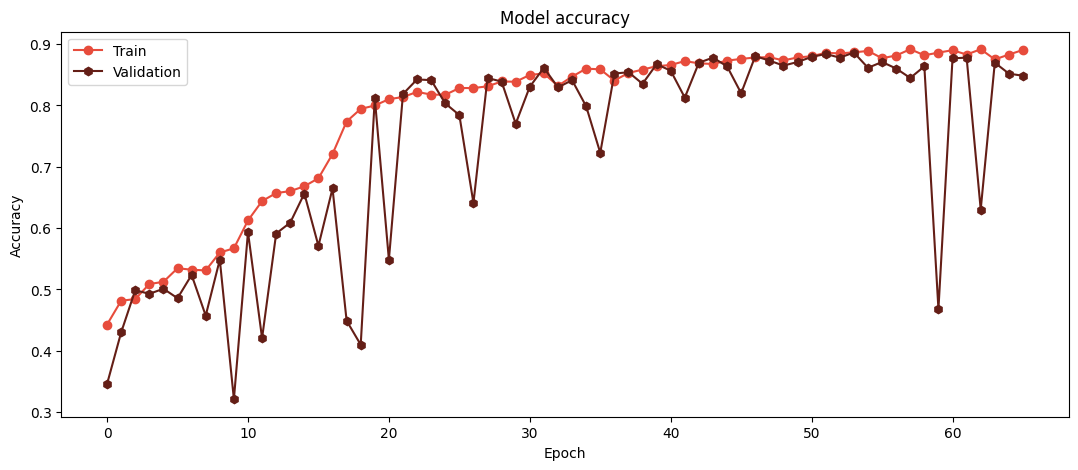

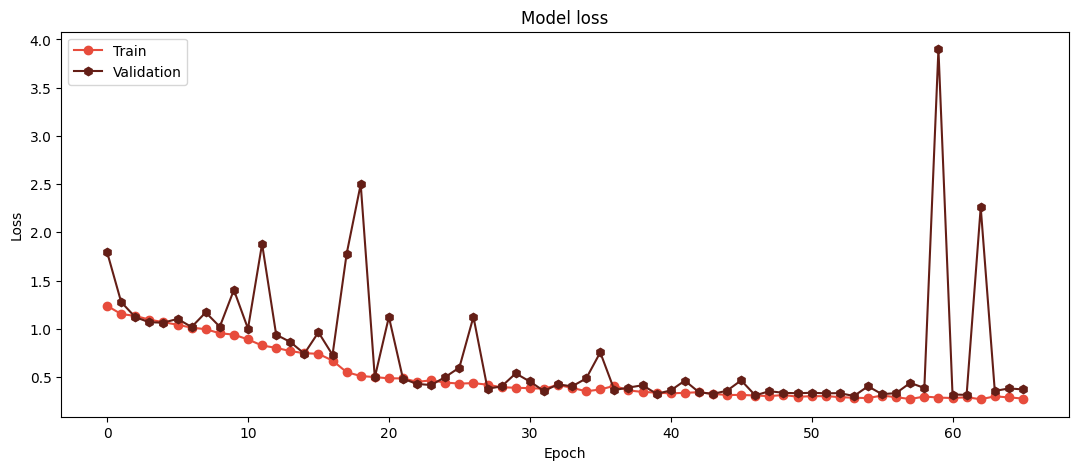

In [26]:
# Plot training & validation accuracy values
plt.figure(figsize=(13,5))
plt.plot(history.history['accuracy'],color="#E74C3C", marker='o')
plt.plot(history.history['val_accuracy'], color='#641E16', marker='h')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(13,5))
plt.plot(history.history['loss'],color="#E74C3C", marker='o')
plt.plot(history.history['val_loss'], color='#641E16', marker='h')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend( ['Train', 'Validation'], loc='upper left')
plt.show()

In [27]:
# Save full model in HDF5 (.h5) format
model.save('/kaggle/working/eye_disease_model.h5')

In [28]:
# Load the saved model
# If the best model is captured by the early stopping mechanism then best_model = model
# best_model = model

best_model = load_model(r'/kaggle/working/eye_disease_model.h5')



# Evaluate the model
train_loss, train_accuracy = best_model.evaluate(train_dataset)
val_loss, val_accuracy = best_model.evaluate(val_dataset)
test_loss, test_accuracy = best_model.evaluate(test_dataset)

print(f"train loss: {train_loss}")
print(f"train accuracy: {train_accuracy}")
print('----'*6)
print(f"val loss: {val_loss}")
print(f"val accuracy: {val_accuracy}")
print('----'*6)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

159/159 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.8941 - loss: 0.2674
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.8740 - loss: 0.2844
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.8753 - loss: 0.3177
train loss: 0.2573799788951874
train accuracy: 0.8967971801757812
------------------------
val loss: 0.302102655172348
val accuracy: 0.8862559199333191
------------------------
Test loss: 0.3510490953922272
Test accuracy: 0.8850710988044739


In [29]:
# Assuming best_model is your trained Keras model

# Get the predicted labels from the model
y_pred = np.argmax( best_model.predict(test_dataset) , axis=1 ) # Convert probabilities to class indices
y_true = test_labels

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(conf_mat)

# Get the class labels from the LabelEncoder
class_labels = label_encoder.classes_

# Compute classification report
report = classification_report(y_true, y_pred, target_names=class_labels)

print("\nClassification Report:")
print(report)

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step
Confusion Matrix:
[[184   2  14   8]
 [  0 216   0   4]
 [ 19   1 147  34]
 [  3   1  11 200]]

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.89      0.88      0.89       208
diabetic_retinopathy       0.98      0.98      0.98       220
            glaucoma       0.85      0.73      0.79       201
              normal       0.81      0.93      0.87       215

            accuracy                           0.89       844
           macro avg       0.89      0.88      0.88       844
        weighted avg       0.89      0.89      0.88       844



Total Number Of Test data:  844


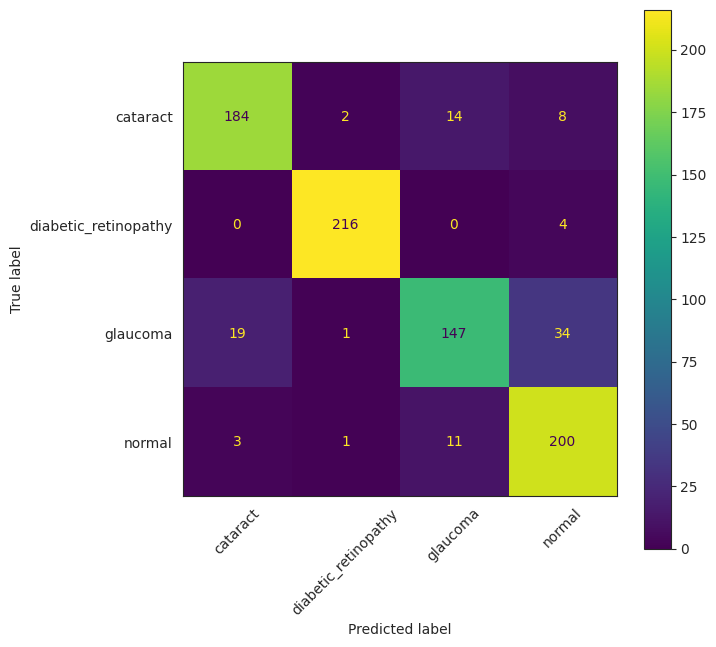

In [30]:
#Confusion matrix
print('Total Number Of Test data: ', len(test_labels))

sn.set_style("white")
def plot_confusion_matrix(conf_mat, classes):
    """
    This function prints and plots the confusion matrix.
    """
    fig, ax = plt.subplots(figsize=(7,7)) # change the plot size
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
    disp = disp.plot(include_values=True,cmap='viridis', ax=ax, xticks_rotation=45)
    plt.show()

# Get your confusion matrix
conf_mat = conf_mat

# Using label_encoder.classes_ guarantees that class_names matches 
# the order that was used during the one-hot encoding process
class_names = label_encoder.classes_

# Now plot using the function
plot_confusion_matrix(conf_mat, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


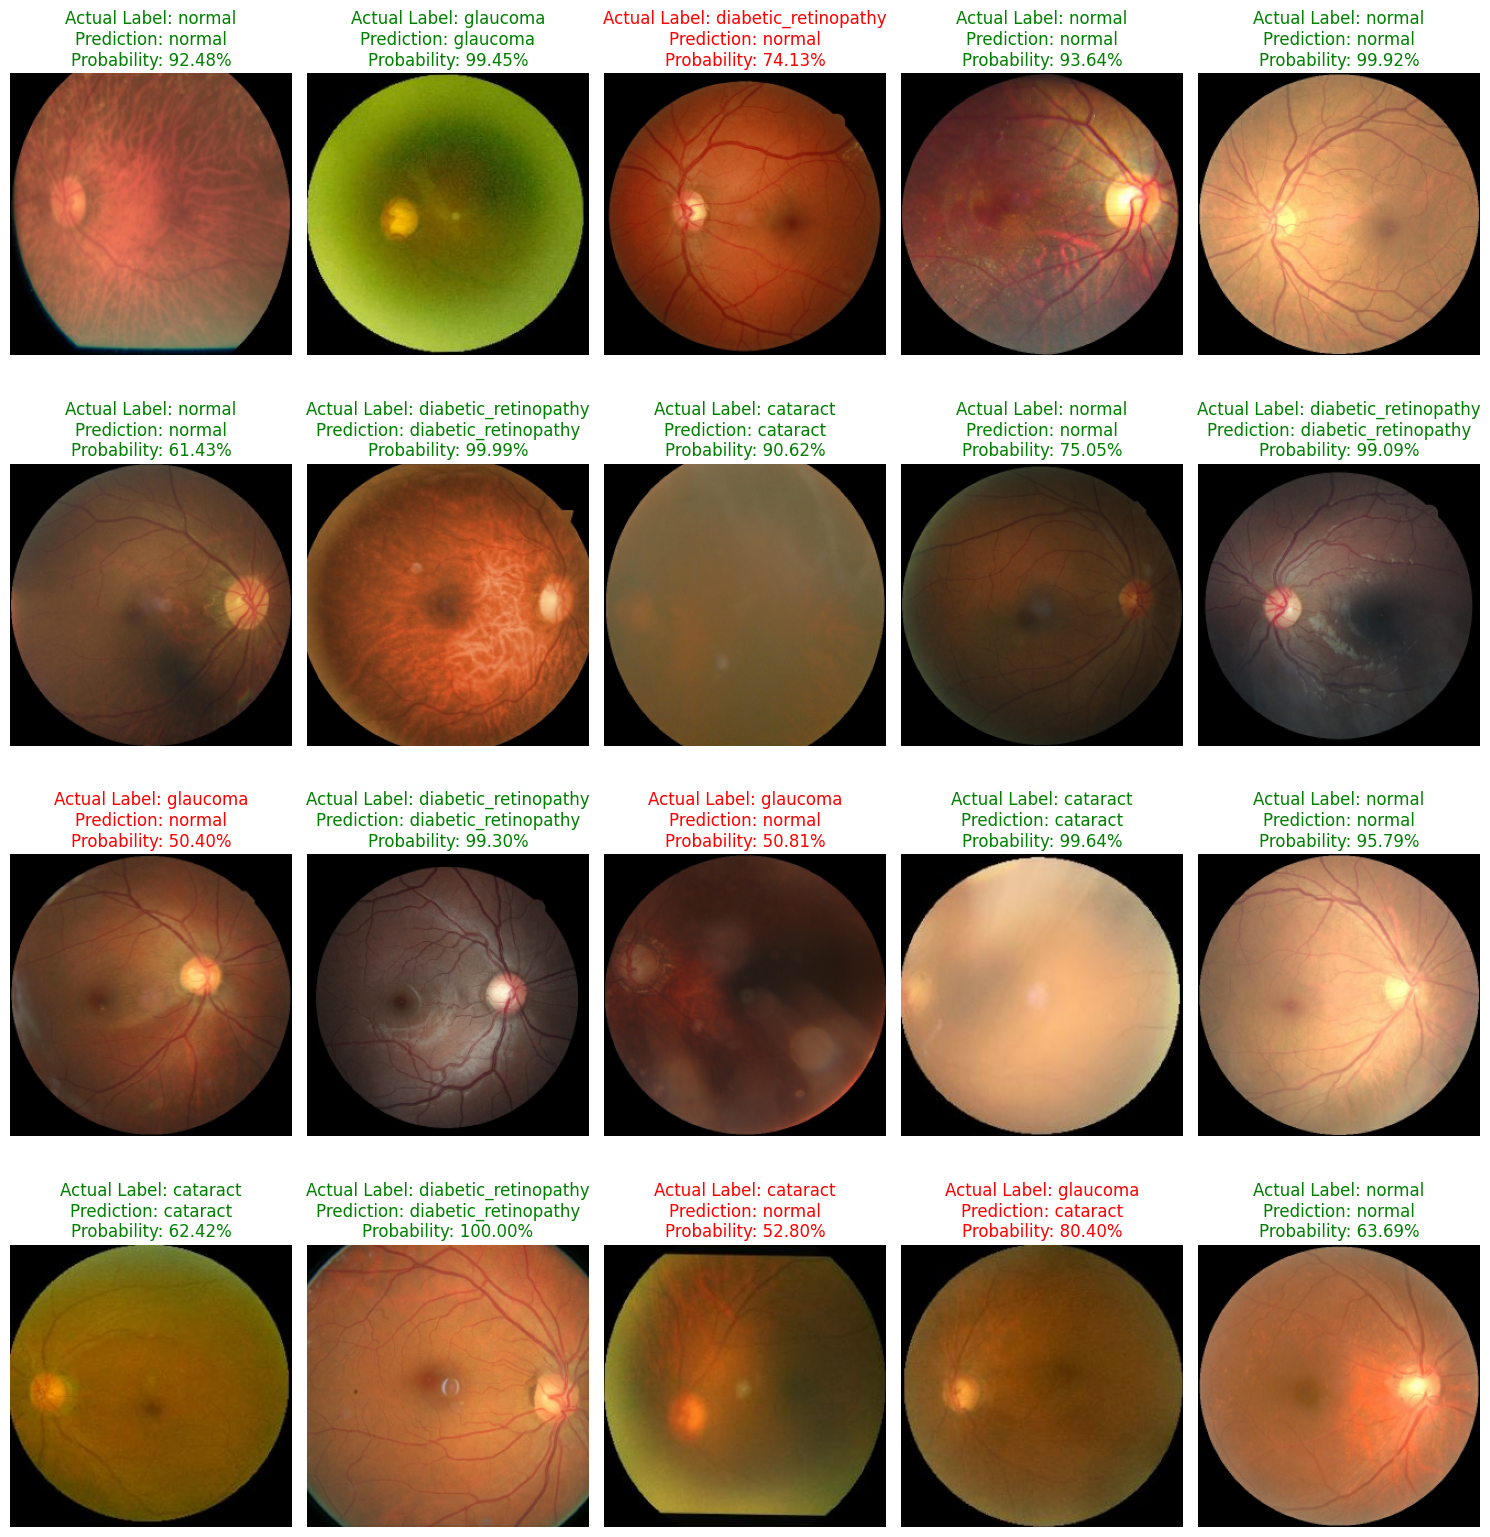

In [31]:
# probability explanation in below function: 
# For example, if the model predicts an image as class B with a probability of 0.7 (or 70%), 
# the plot will show "Probability: 70%". 
# This means the model is 70% confident that the image belongs to class B.


def plot_test_predictions(model, test_dataset, class_labels, num_images=20):
    """
    Plots the predictions of a model on the test dataset.

    Parameters:
    - model: Trained Keras model to be used for prediction.
    - test_dataset: TensorFlow dataset containing the test images and labels.
    - class_labels: List of class labels.
    - num_images: Number of test images to plot (default is 20).
    """

    # Initialize lists to accumulate images and labels
    images = []
    true_labels = []
    pred_labels = []
    pred_probs = []

    for batch_images, batch_labels in test_dataset:
        # Predict on the batch
        batch_pred_probs = model.predict(batch_images)
        batch_pred_labels = np.argmax(batch_pred_probs, axis=1)

        # Accumulate images and labels
        images.extend(batch_images)
        true_labels.extend(batch_labels)
        pred_labels.extend(batch_pred_labels)
        pred_probs.extend(np.max(batch_pred_probs, axis=1) * 100)

        if len(images) >= num_images:
            break

    # Plot the images with predictions
    plt.figure(figsize=(15, 20))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        actual_label = class_labels[true_labels[i]]
        predicted_label = class_labels[pred_labels[i]]
        probability = pred_probs[i]  # Probability of the predicted class

        color = 'green' if actual_label == predicted_label else 'red'
        plt.title(f"Actual Label: {actual_label}\nPrediction: {predicted_label}\nProbability: {probability:.2f}%",
                  color=color, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Use the function
plot_test_predictions(best_model, test_dataset, class_labels=class_names, num_images=20)


# Transfer Learning

By setting `include_top=False`, the last fully connected layers are removed and only the base convolutional network is left, which is used when a pre-trained network is required to serve as a feature extractor in transfer learning setup followed by subsequent training of new top layer specific to your dataset.

When you set `base_model.trainable = True`, all the layers in the base model become trainable. In this case, these layers will have their weights updated during training. This method is often used in situations where you have a lot of training data and wish to fine-tune the entire model on your new data for perhaps better performance.

In [35]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, regularizers

# Load EfficientNetB0 base (without top classifier layers)
base_model = EfficientNetB0(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet'
)

# Enable fine-tuning
base_model.trainable = True

# Build model
model = models.Sequential([
    layers.Input(shape=(256, 256, 3)),  # ✅ Explicit Input layer (important!)
    base_model,
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # optional regularization
    layers.Dropout(0.4),
    layers.Dense(len(class_names), activation='softmax')
])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 1280)     │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 1280)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,712,615 (17.98 MB)

 Trainable params: 4,668,032 (17.81 MB)

 Non-trainable params: 44,583 (174.16 KB)

Here I tried to use the .keras extension to save the model, but after saving and reloading in transfer learning mode, the weights were not saved correctly, while it worked fine in non-transfer mode. I didn't understand the reason, so I made a custom function to use the .h5 format.

In [36]:
import numpy as np
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import save_model

#------------------------------------------------------------------------------------------------------#
# Custom Callback Class: EarlyStopping + Checkpoint (.h5 saving)
class CustomEarlyStoppingAndCheckpoint(Callback):
    def __init__(self, save_path, patience=12, verbose=1, save_best_only=True):
        super().__init__()
        self.save_path = save_path
        self.patience = patience
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.best_weights = None
        self.best_acc = -np.Inf
        self.best_loss = np.Inf
        self.wait = 0
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_accuracy')
        if val_acc is None or val_loss is None:
            return

        if val_loss < self.best_loss:
            self.best_loss = val_loss
            if self.save_best_only:
                # ✅ Save the full model in .h5 format
                self.model.save(self.save_path, include_optimizer=True, save_format='h5')
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: val_loss improved to {val_loss:.4f}, saving model to {self.save_path}")

        # Update best weights for early stopping based on val_accuracy
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            self.best_weights = self.model.get_weights()
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: early stopping triggered.")
                if self.best_weights is not None:
                    self.model.set_weights(self.best_weights)
                    if self.verbose > 0:
                        print("Restored model weights from the best epoch based on val_accuracy.")

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and self.verbose > 0:
            print(f"Training stopped early at epoch {self.stopped_epoch + 1}")

#----------------------------------------------------------------------------------------------------------#

# 👇 Compile your model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 👇 Use the callback
callbacks = [
    CustomEarlyStoppingAndCheckpoint(
        save_path='/kaggle/working/eye_disease_model_transfer.h5',
        patience=12,
        verbose=1,
        save_best_only=True
    )
]

# 👇 Fit the model
history = model.fit(
    x=train_dataset,
    validation_data=val_dataset,
    epochs=150,
    callbacks=callbacks
)


Epoch 1/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.6491 - loss: 6.5252
Epoch 1: val_loss improved to 7.1181, saving model to /kaggle/working/eye_disease_model_transfer.h5
159/159 ━━━━━━━━━━━━━━━━━━━━ 146s 437ms/step - accuracy: 0.6497 - loss: 6.5135 - val_accuracy: 0.2464 - val_loss: 7.1181
Epoch 2/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.8204 - loss: 1.7963 - val_accuracy: 0.2464 - val_loss: 13.4017
Epoch 3/150
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8415 - loss: 0.8342
Epoch 3: val_loss improved to 6.6836, saving model to /kaggle/working/eye_disease_model_transfer.h5
159/159 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.8418 - loss: 0.8329 - val_accuracy: 0.2476 - val_loss: 6.6836
Epoch 4/150
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8504 - loss: 0.6533
Epoch 4: val_loss improved to 0.9675, saving model to /kaggle/working/eye_disease_model_transfer.h5
159/159 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.8505

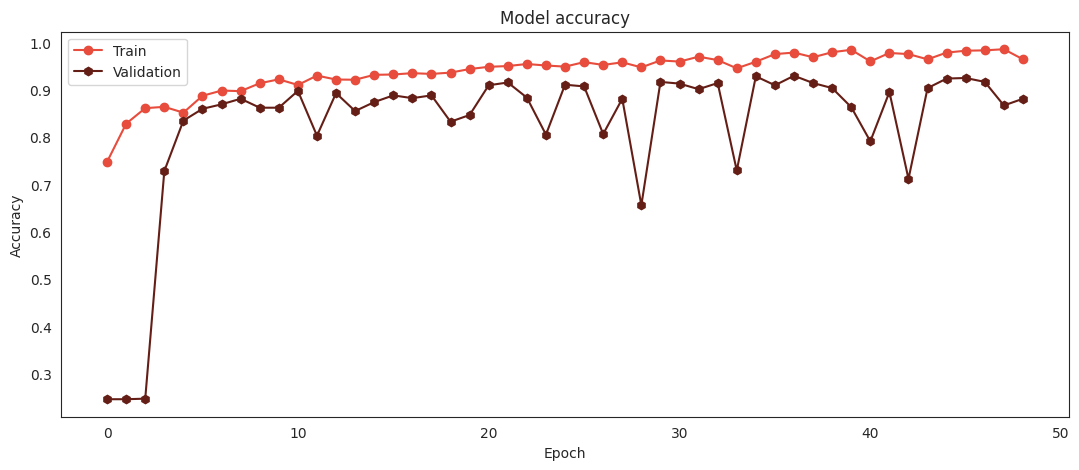

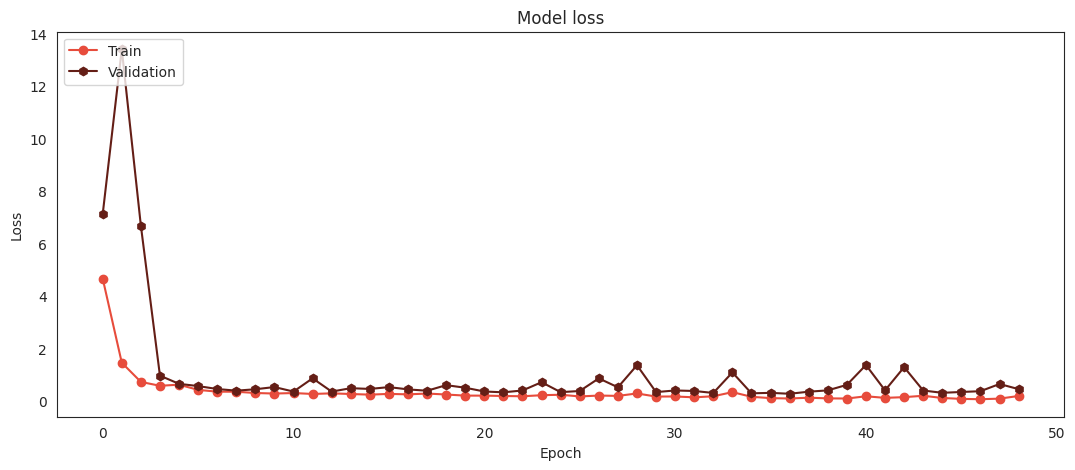

In [37]:
# Plot training & validation accuracy values
plt.figure(figsize=(13,5))
plt.plot(history.history['accuracy'],color="#E74C3C", marker='o')
plt.plot(history.history['val_accuracy'], color='#641E16', marker='h')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(13,5))
plt.plot(history.history['loss'],color="#E74C3C", marker='o')
plt.plot(history.history['val_loss'], color='#641E16', marker='h')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend( ['Train', 'Validation'], loc='upper left')
plt.show()

In [38]:
# Load the saved model
# If the best model is captured by the early stopping mechanism then best_model = model
# best_model = model

best_model = load_model(r'/kaggle/working/eye_disease_model_transfer.h5')
best_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Evaluate the model
train_loss, train_accuracy = best_model.evaluate(train_dataset)
val_loss, val_accuracy = best_model.evaluate(val_dataset)
test_loss, test_accuracy = best_model.evaluate(test_dataset)

print(f"train loss: {train_loss}")
print(f"train accuracy: {train_accuracy}")
print('----'*6)
print(f"val loss: {val_loss}")
print(f"val accuracy: {val_accuracy}")
print('----'*6)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

159/159 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9656 - loss: 0.1333
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9252 - loss: 0.3155
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9358 - loss: 0.2675
train loss: 0.13485877215862274
train accuracy: 0.9667853116989136
------------------------
val loss: 0.2780015170574188
val accuracy: 0.9300947785377502
------------------------
Test loss: 0.24066786468029022
Test accuracy: 0.9383886456489563


In [39]:
# Assuming best_model is your trained Keras model

# Get the predicted labels from the model
y_pred = np.argmax( best_model.predict(test_dataset) , axis=1 ) # Convert probabilities to class indices
y_true = test_labels

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(conf_mat)

# Get the class labels from the LabelEncoder
class_labels = label_encoder.classes_

# Compute classification report
report = classification_report(y_true, y_pred, target_names=class_labels)

print("\nClassification Report:")
print(report)

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step
Confusion Matrix:
[[195   0  10   3]
 [  1 219   0   0]
 [  1   1 178  21]
 [  3   1  11 200]]

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.97      0.94      0.96       208
diabetic_retinopathy       0.99      1.00      0.99       220
            glaucoma       0.89      0.89      0.89       201
              normal       0.89      0.93      0.91       215

            accuracy                           0.94       844
           macro avg       0.94      0.94      0.94       844
        weighted avg       0.94      0.94      0.94       844



Total Number Of Test data:  844


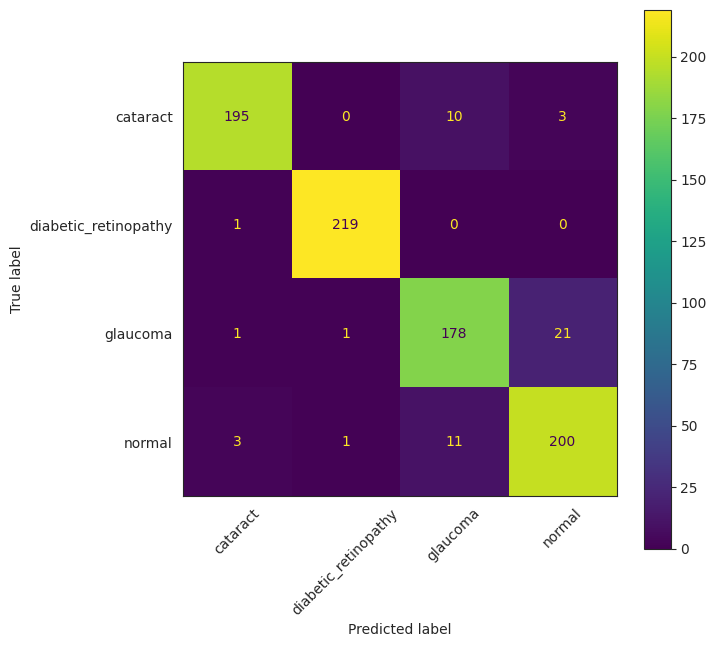

In [40]:
#Confusion matrix
print('Total Number Of Test data: ', len(test_labels))

sn.set_style("white")
def plot_confusion_matrix(conf_mat, classes):
    """
    This function prints and plots the confusion matrix.
    """
    fig, ax = plt.subplots(figsize=(7,7)) # change the plot size
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
    disp = disp.plot(include_values=True,cmap='viridis', ax=ax, xticks_rotation=45)
    plt.show()

# Get your confusion matrix
conf_mat = conf_mat

# Using label_encoder.classes_ guarantees that class_names matches 
# the order that was used during the one-hot encoding process
class_names = label_encoder.classes_

# Now plot using the function
plot_confusion_matrix(conf_mat, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


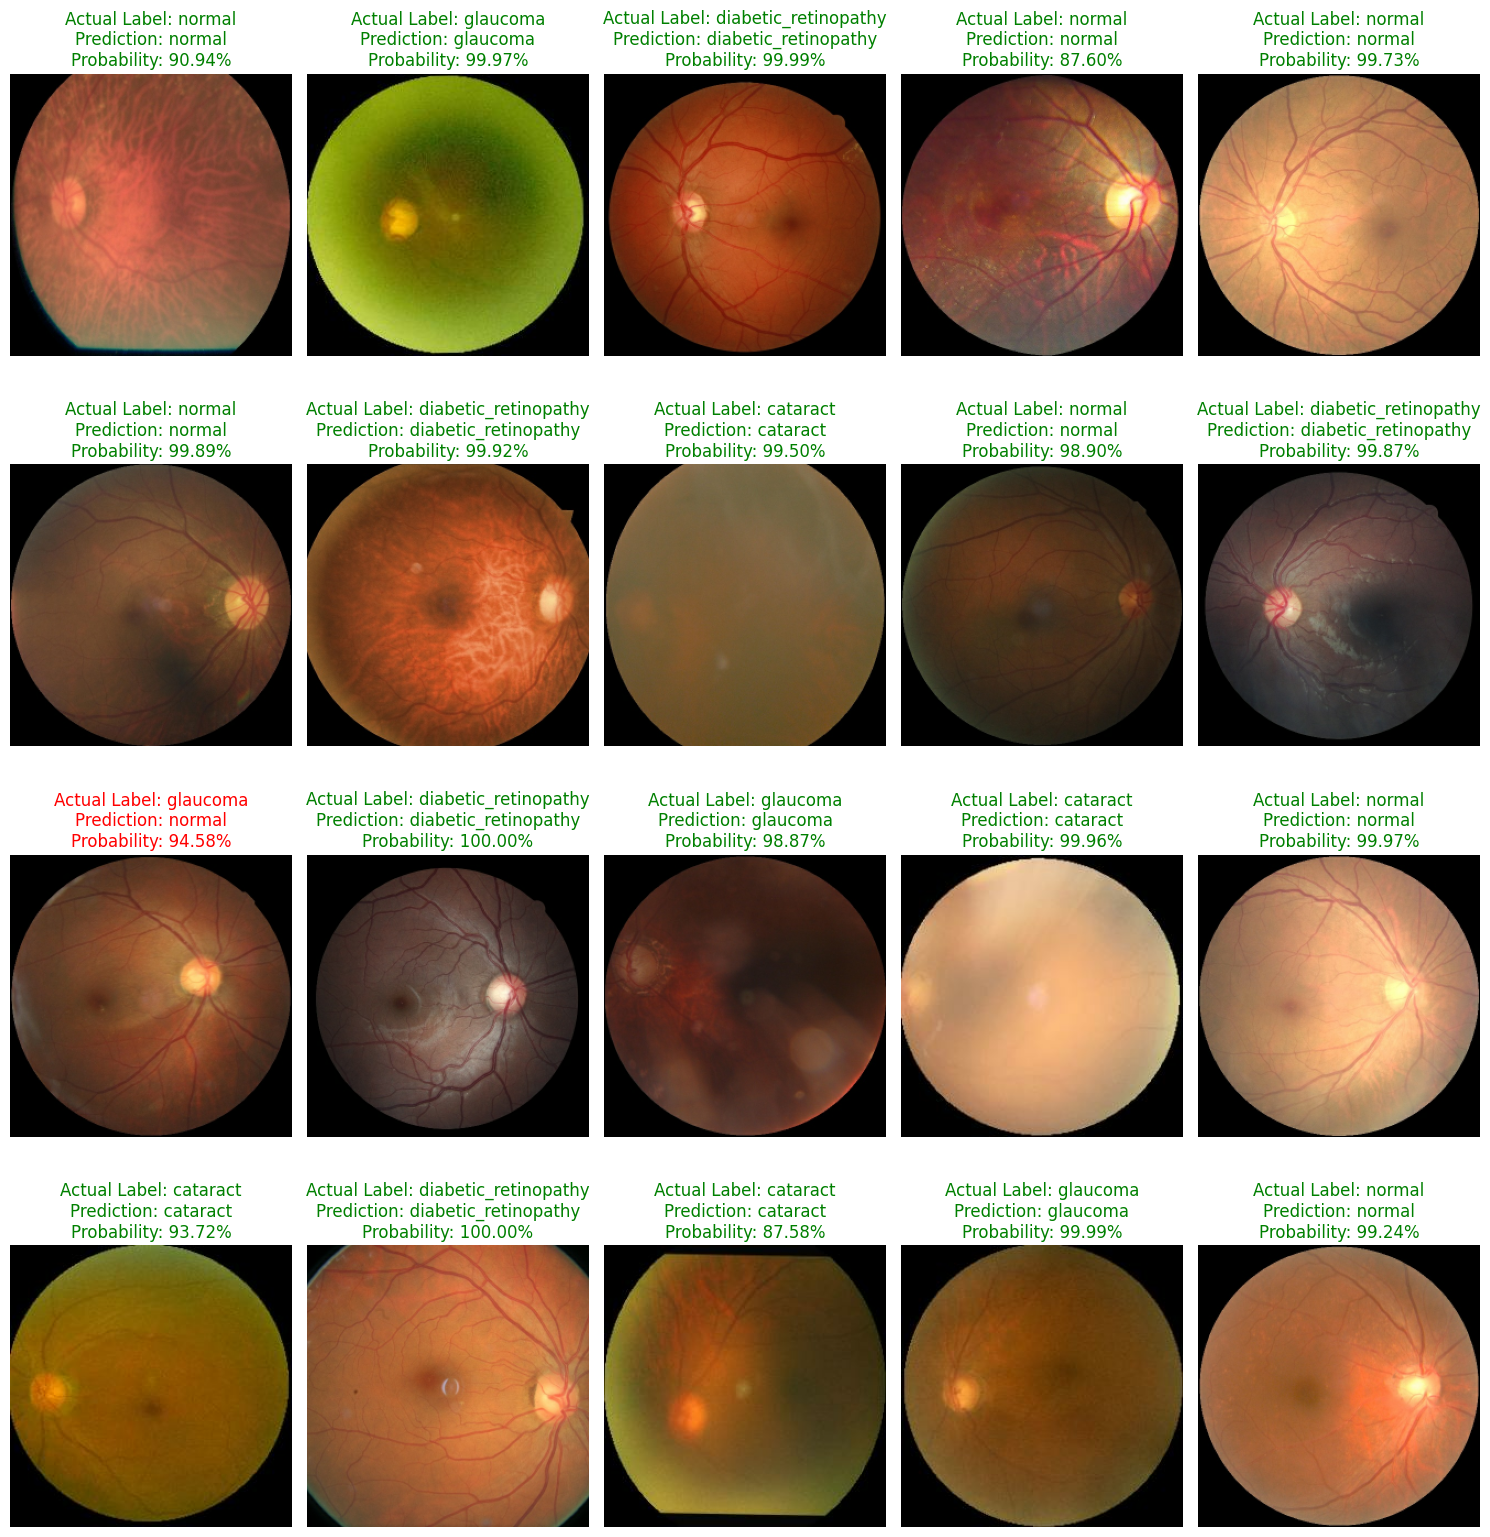

In [41]:
# probability explanation in below function: 
# For example, if the model predicts an image as class B with a probability of 0.7 (or 70%), 
# the plot will show "Probability: 70%". 
# This means the model is 70% confident that the image belongs to class B.

def plot_test_predictions(model, test_dataset, class_labels, num_images=20):
    """
    Plots the predictions of a model on the test dataset.

    Parameters:
    - model: Trained Keras model to be used for prediction.
    - test_dataset: TensorFlow dataset containing the test images and labels.
    - class_labels: List of class labels.
    - num_images: Number of test images to plot (default is 20).
    """

    # Initialize lists to accumulate images and labels
    images = []
    true_labels = []
    pred_labels = []
    pred_probs = []

    for batch_images, batch_labels in test_dataset:
        # Predict on the batch
        batch_pred_probs = model.predict(batch_images)
        batch_pred_labels = np.argmax(batch_pred_probs, axis=1)

        # Accumulate images and labels
        images.extend(batch_images)
        true_labels.extend(batch_labels)
        pred_labels.extend(batch_pred_labels)
        pred_probs.extend(np.max(batch_pred_probs, axis=1) * 100)

        if len(images) >= num_images:
            break

    # Plot the images with predictions
    plt.figure(figsize=(15, 20))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        actual_label = class_labels[true_labels[i]]
        predicted_label = class_labels[pred_labels[i]]
        probability = pred_probs[i]  # Probability of the predicted class

        color = 'green' if actual_label == predicted_label else 'red'
        plt.title(f"Actual Label: {actual_label}\nPrediction: {predicted_label}\nProbability: {probability:.2f}%",
                  color=color, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Use the function
plot_test_predictions(best_model, test_dataset, class_labels=class_names, num_images=20)

In [42]:
from sklearn.preprocessing import LabelEncoder
import pickle

# Assuming you have already used LabelEncoder on df['class']
label_encoder = LabelEncoder()
label = label_encoder.fit_transform(df['class'])
df['class'] = label

# Create class mapping dictionary
class_names = label_encoder.classes_
class_numbers = label_encoder.transform(class_names)
class_dict = dict(zip(class_numbers, class_names))

# Print class indices
print("Class indices:")
print(class_dict)


Class indices:
{0: 0, 1: 1, 2: 2, 3: 3}


In [44]:
import pickle

# Your class-to-index mapping
label_to_index = {'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}

# Reverse it to index-to-label
index_to_label = {v: k for k, v in label_to_index.items()}

# Save to .pkl
with open('/kaggle/working/eye_disease_class_indices.pkl', 'wb') as f:
    pickle.dump(index_to_label, f)

print("Saved class indices:", index_to_label)


Saved class indices: {0: 'cataract', 1: 'diabetic_retinopathy', 2: 'glaucoma', 3: 'normal'}


In [47]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def predict_image(model, image_path, class_indices, target_size=(256, 256)):
    # Safely invert the dictionary
    try:
        index_to_label = {v: k for k, v in class_indices.items()}
    except Exception as e:
        print("Error inverting class indices:", e)
        return None, None

    # Load and preprocess image
    img = tf.keras.utils.load_img(image_path, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Predict
    prediction = model.predict(img_array)
    predicted_index = int(np.argmax(prediction))
    confidence = float(np.max(prediction)) * 100

    # Check and fetch label
    if predicted_index not in index_to_label:
        print(f"Predicted index {predicted_index} not found in index_to_label.")
        return None, None

    label = index_to_label[predicted_index]

    # Plot
    plt.imshow(img)
    plt.title(f"Prediction: {label} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    return label, confidence


In [48]:
# Load the model
model = tf.keras.models.load_model('/kaggle/working/eye_disease_model_transfer.h5')

# Load the class index mapping
import pickle
with open('/kaggle/working/eye_disease_class_indices.pkl', 'rb') as f:
    class_indices = pickle.load(f)

# Predict a single image
image_path = "/kaggle/input/eye-diseases-classification/dataset/cataract/103_left.jpg"
label, confidence = predict_image(model, image_path, class_indices)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted index 0 not found in index_to_label.


In [50]:
import pickle

# Load the class indices from the pickle file
with open('/kaggle/working/eye_disease_class_indices.pkl', 'rb') as f:
    class_indices = pickle.load(f)

# Print the labels (class names and their corresponding indices)
print("Class indices:")
for label, idx in class_indices.items():
    print(f"{label}: {idx}")



Class indices:
0: cataract
1: diabetic_retinopathy
2: glaucoma
3: normal


In [51]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Index to label mapping
index_to_label = {
    0: 'cataract',
    1: 'diabetic_retinopathy',
    2: 'glaucoma',
    3: 'normal'
}

def predict_image(model, image_path, index_to_label, target_size=(256, 256)):
    # Load and preprocess image
    img = tf.keras.utils.load_img(image_path, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize if needed

    # Make prediction
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    confidence = np.max(prediction) * 100

    # Get label from index
    label = index_to_label[predicted_index]

    # Show image and prediction
    plt.imshow(img)
    plt.title(f"Prediction: {label} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    return label, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


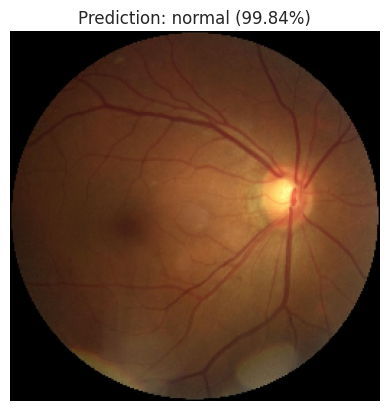

In [54]:
image_path = "/kaggle/input/eye-diseases-classification/dataset/normal/2354_right.jpg"
label, confidence = predict_image(model, image_path, index_to_label)
